In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score

In [2]:
DATASETS_2D = ['data/dane_2D_1.txt', 'data/dane_2D_2.txt', 'data/dane_2D_3.txt', 'data/dane_2D_4.txt',
               'data/dane_2D_5.txt', 'data/dane_2D_6.txt', 'data/dane_2D_7.txt', 'data/dane_2D_8.txt']

DATASETS_2D_Ks = [10, 10, 5, 5, 37, 17, 5, 5]

from sklearn.preprocessing import MinMaxScaler


def get_data_w_labels(filename):
    data = np.loadtxt(filename)
    x, y = np.hsplit(data, [-1])
    return MinMaxScaler().fit(x).transform(x), y


def get_data_wo_labels(filename):
    data = np.loadtxt(filename)
    return MinMaxScaler().fit(data).transform(data)

In [3]:
class KMeans:
    def _init_centroids(self, x, k):
        self._centroids = x[np.random.choice(len(x), k, replace=False)]

    @staticmethod
    def _get_cluster_elems(x, cid, cluster_ids):
        return [xi for xi, c in zip(x, cluster_ids) if c == cid]

    @staticmethod
    def compute_centroids(x, cluster_ids, k):
        return np.array([np.mean(KMeans._get_cluster_elems(x, cid, cluster_ids), axis=0)
                         for cid in range(k)], dtype=float)

    def cluster(self, x, k):
        self._cluster_ids = None
        self._init_centroids(x, k)
        while (True):
            new_cluster_ids = [np.argmin(np.linalg.norm(xi - self._centroids, axis=1)) for xi in x]
            if len(set(new_cluster_ids)) < k:
                break
            new_centroids = self.compute_centroids(x, new_cluster_ids, k)
            if np.allclose(new_centroids, self._centroids):
                break
            self._cluster_ids, self._centroids = new_cluster_ids, new_centroids
        if self._cluster_ids is None:
            return self.cluster(x, k - 1)
        return self._cluster_ids, self._centroids

    @staticmethod
    def error(x, ids, centroids):
        return sum(np.linalg.norm(xi - centroids[id]) ** 2 for xi, id in zip(x, ids))

In [4]:
def get_best_kmeans_clusterization(x, k, trials=10):
    return min((KMeans().cluster(x, k) for _ in range(trials)),
               key=lambda p: KMeans.error(x, *p))

In [5]:
def plot_clusters(ax, x, ids, centroids=None):
    ax.scatter(*np.hsplit(x, 2), c=ids, cmap='gist_rainbow', alpha=.4)
    if centroids is not None:
        ax.plot(*np.hsplit(np.array(centroids), 2), 'o', ms=10, mfc='w', mew=2.5, mec='red')

In [6]:
def handle_2D_dataset(x, y, dataset_name, max_k=10):
    errors, homo = [], []
    fig, _ = plt.subplots(int(max_k ** .5), int(max_k ** .5), figsize=(15, 15))
    for k, ax in zip(range(2, max_k + 1), fig.get_axes()):
        ids, centroids = get_best_kmeans_clusterization(x, k)
        errors.append(KMeans.error(x, ids, centroids))
        homo.append(homogeneity_score(y, ids))
        plot_clusters(ax, x, ids, centroids)
        ax.set_title(f'{k} clusters')
        ax.label_outer()
    fig.tight_layout(pad=3.0)
    fig.suptitle(dataset_name, fontsize=60, y=1.03)

    fig, (ax_err, ax_homo) = plt.subplots(1, 2, figsize=(20, 10))
    ax_err.set_title(f'Number of clusters vs error')
    ax_err.plot(range(2, max_k + 1), errors, 'bx-', ms=10, mec='k')
    ax_err.axvline(len(set(y)), c='red')

    ax_homo.set_title(f'Number of clusters vs homogenity score')
    ax_homo.plot(range(2, max_k + 1), homo, 'bx-', ms=10, mec='k')
    ax_homo.axvline(len(set(y)), c='red')

    fig, ax_true = plt.subplots(figsize=(10, 10))
    plot_clusters(ax_true, x, y)
    ax_true.set_title(f'True clusters')

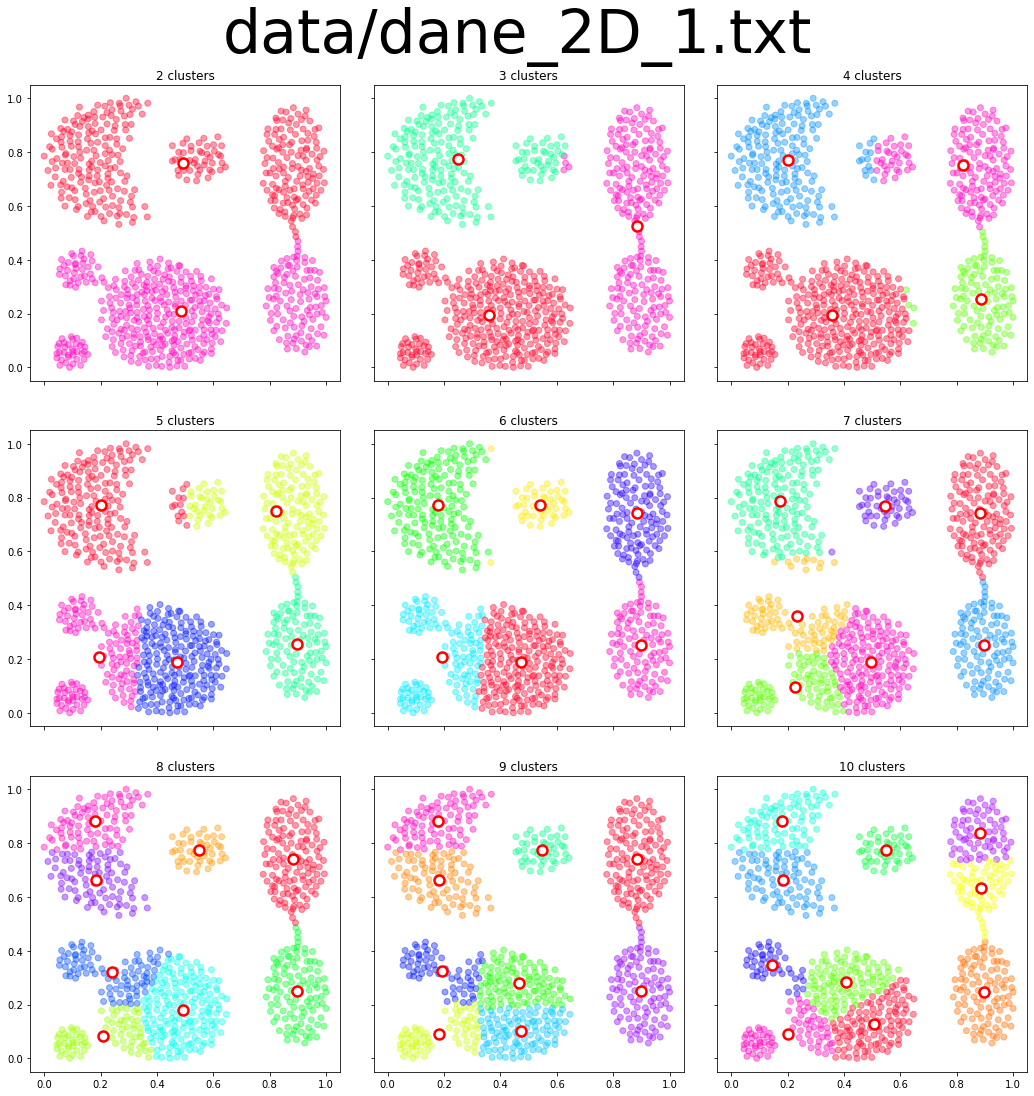

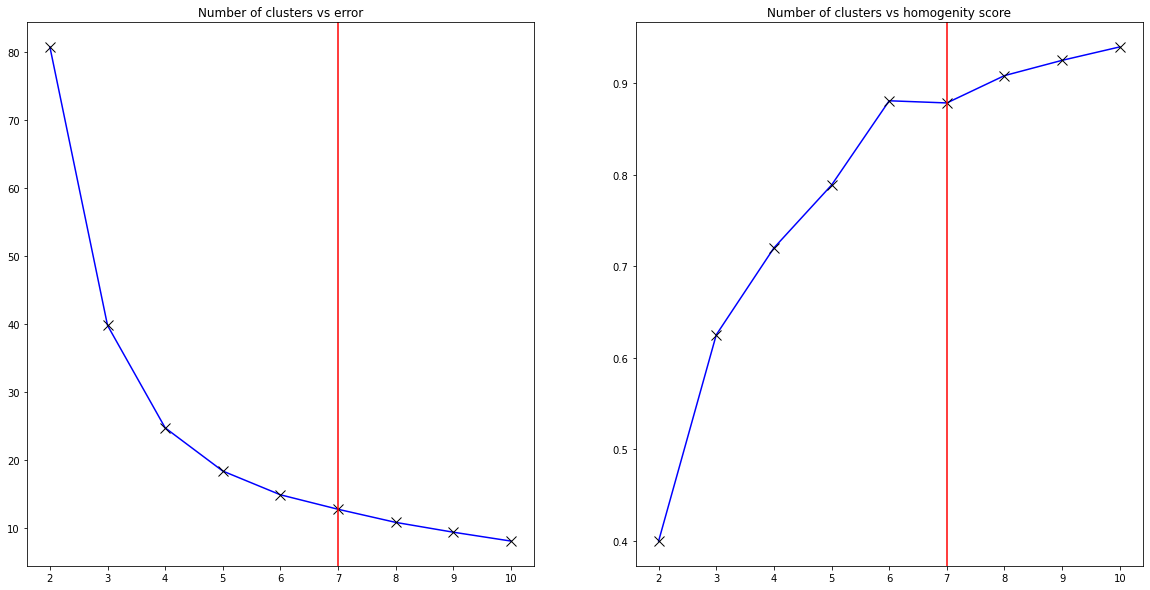

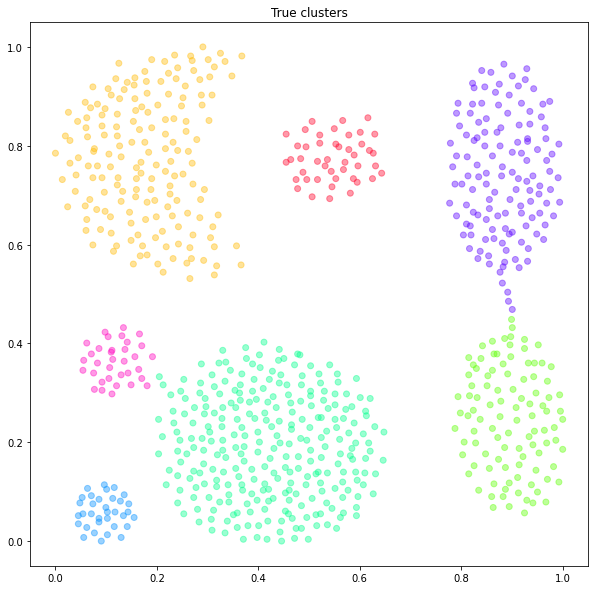

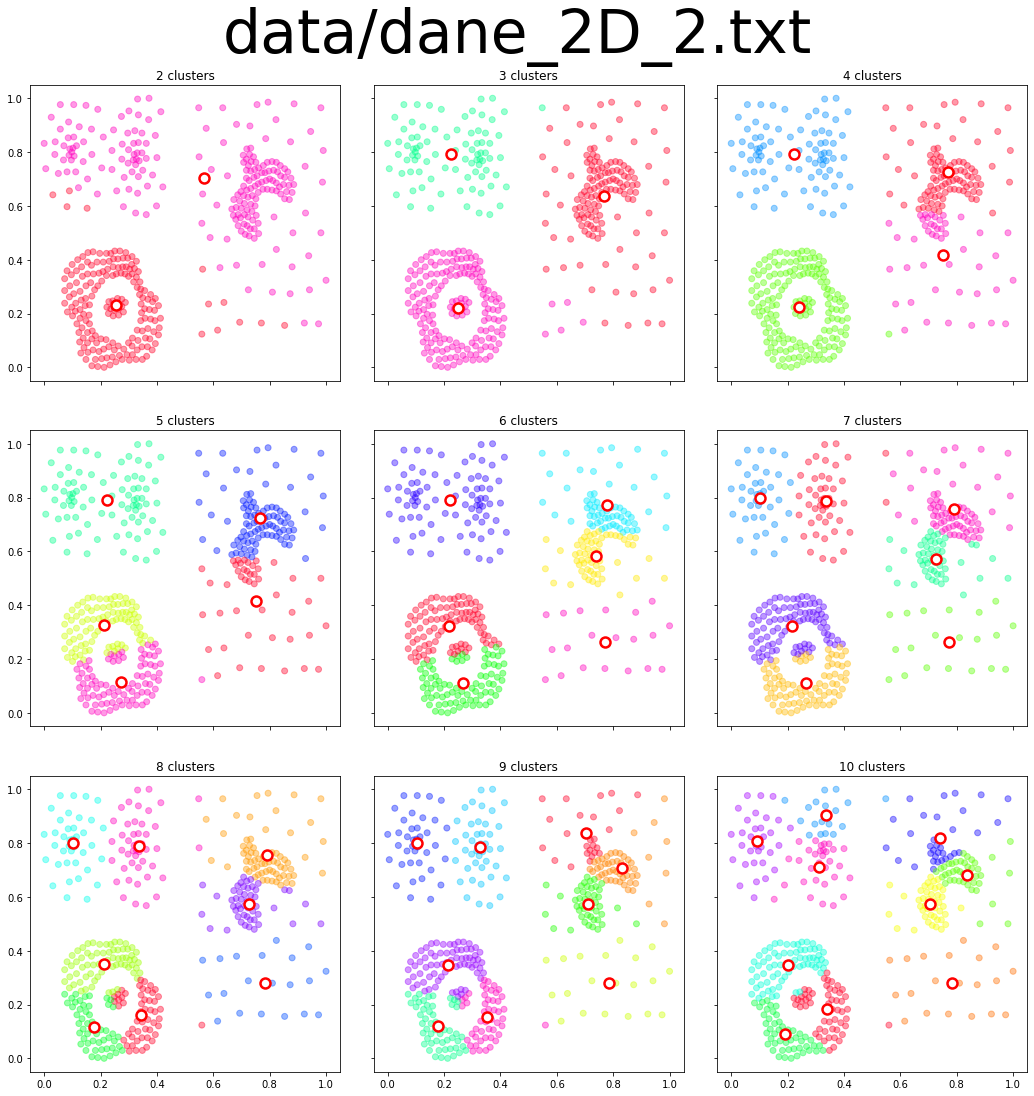

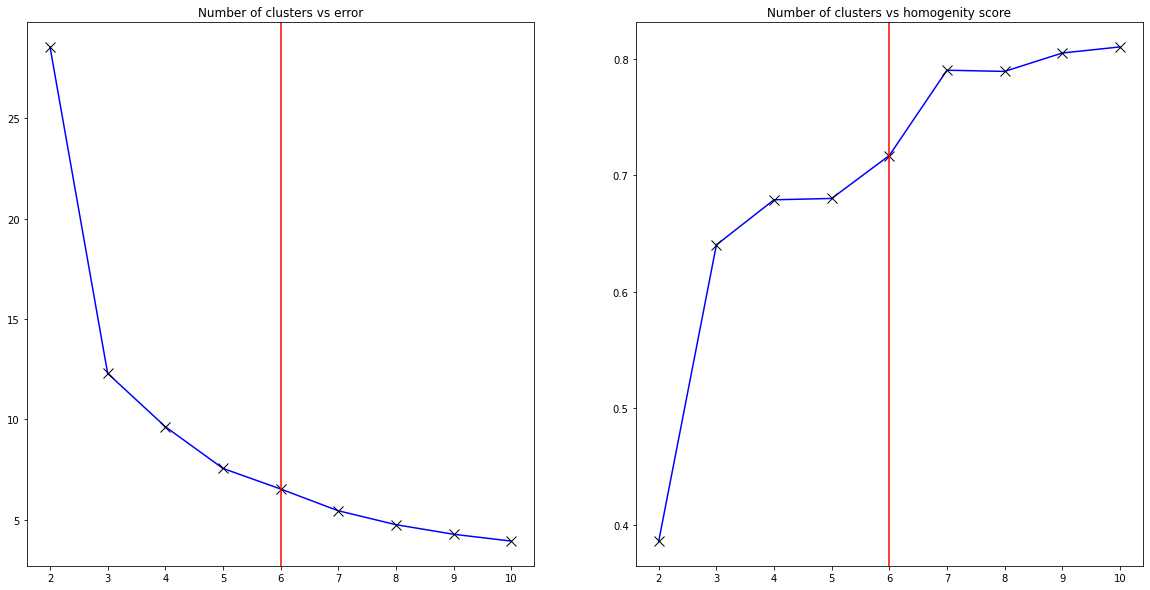

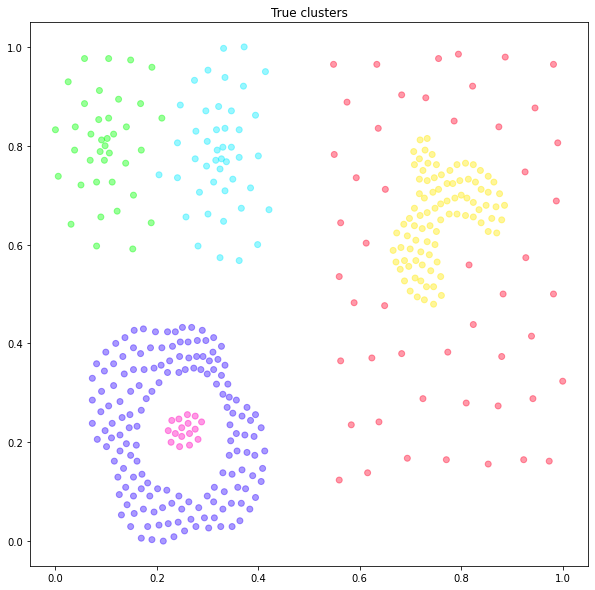

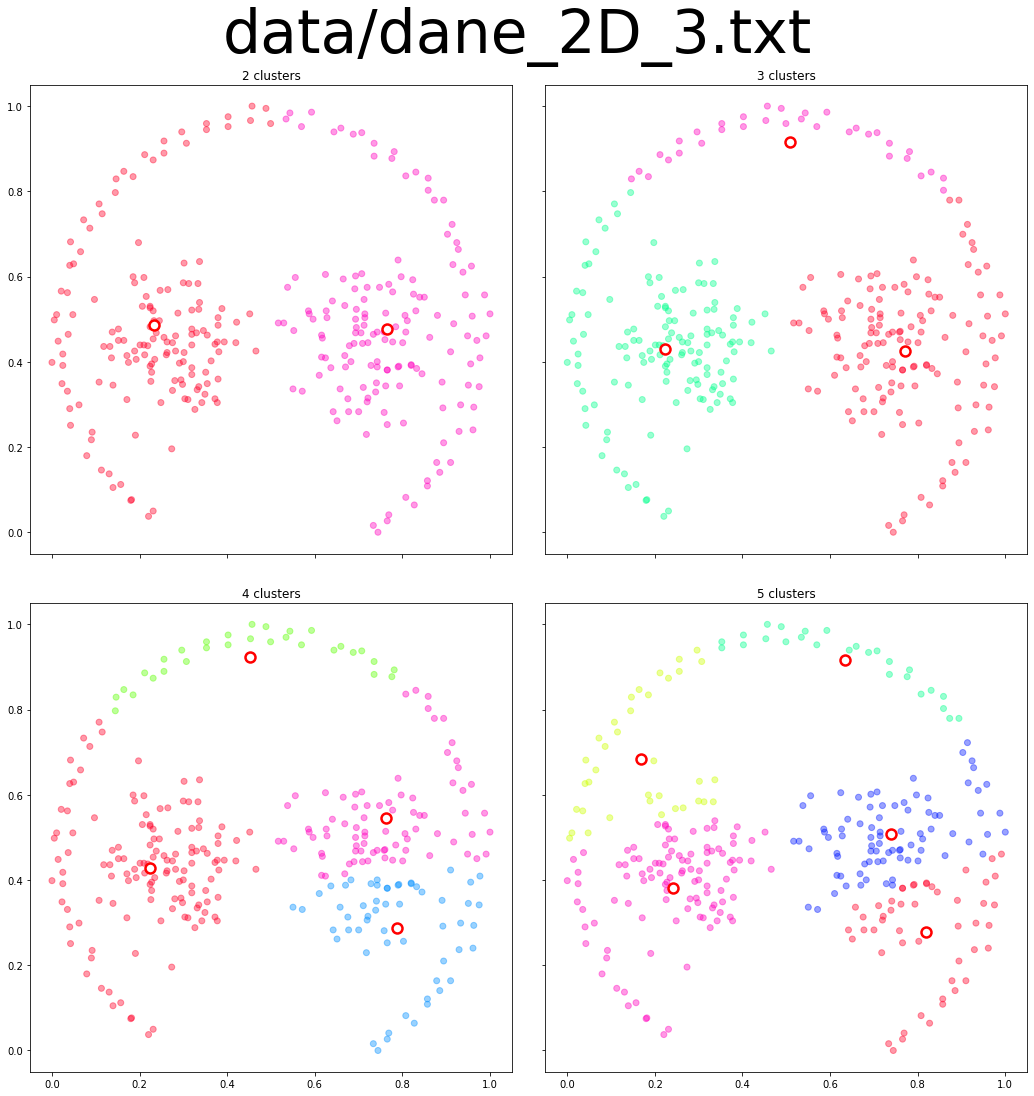

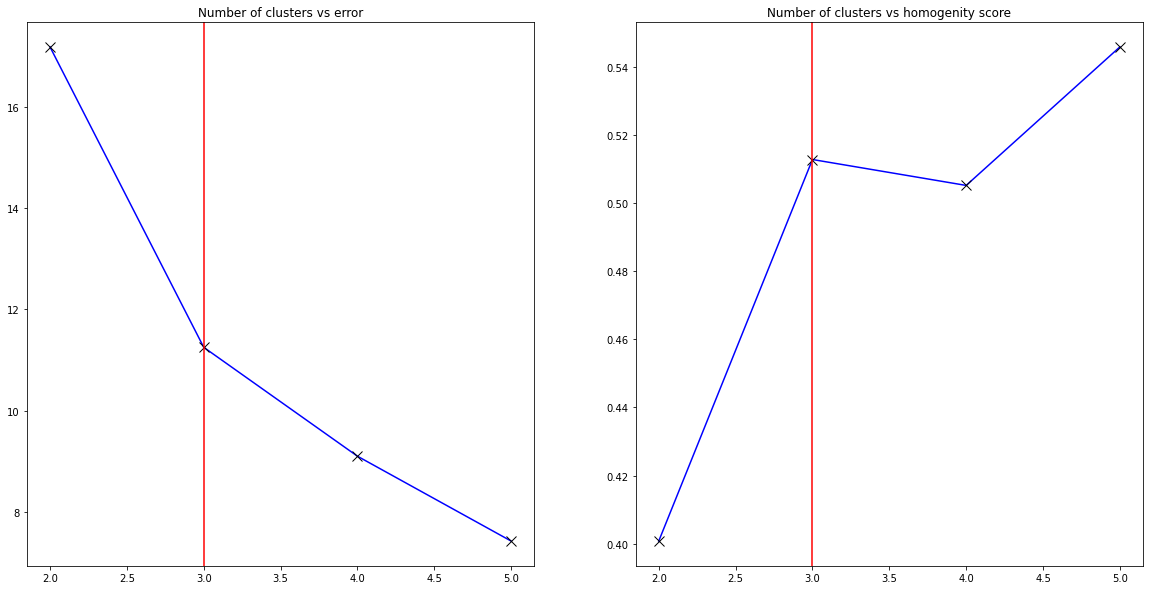

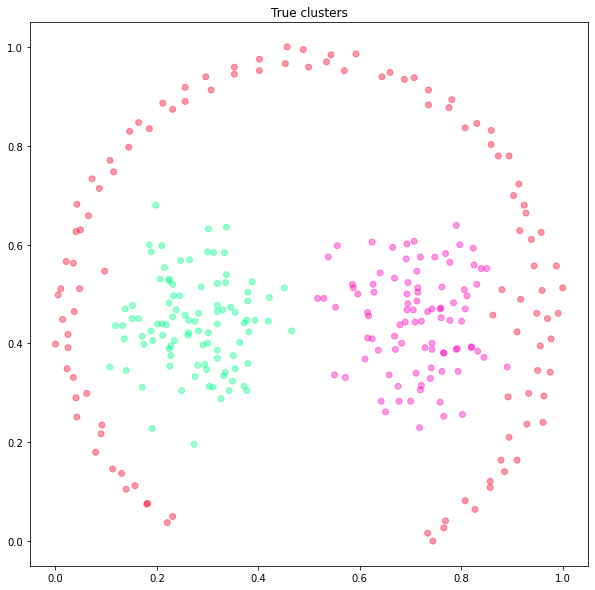

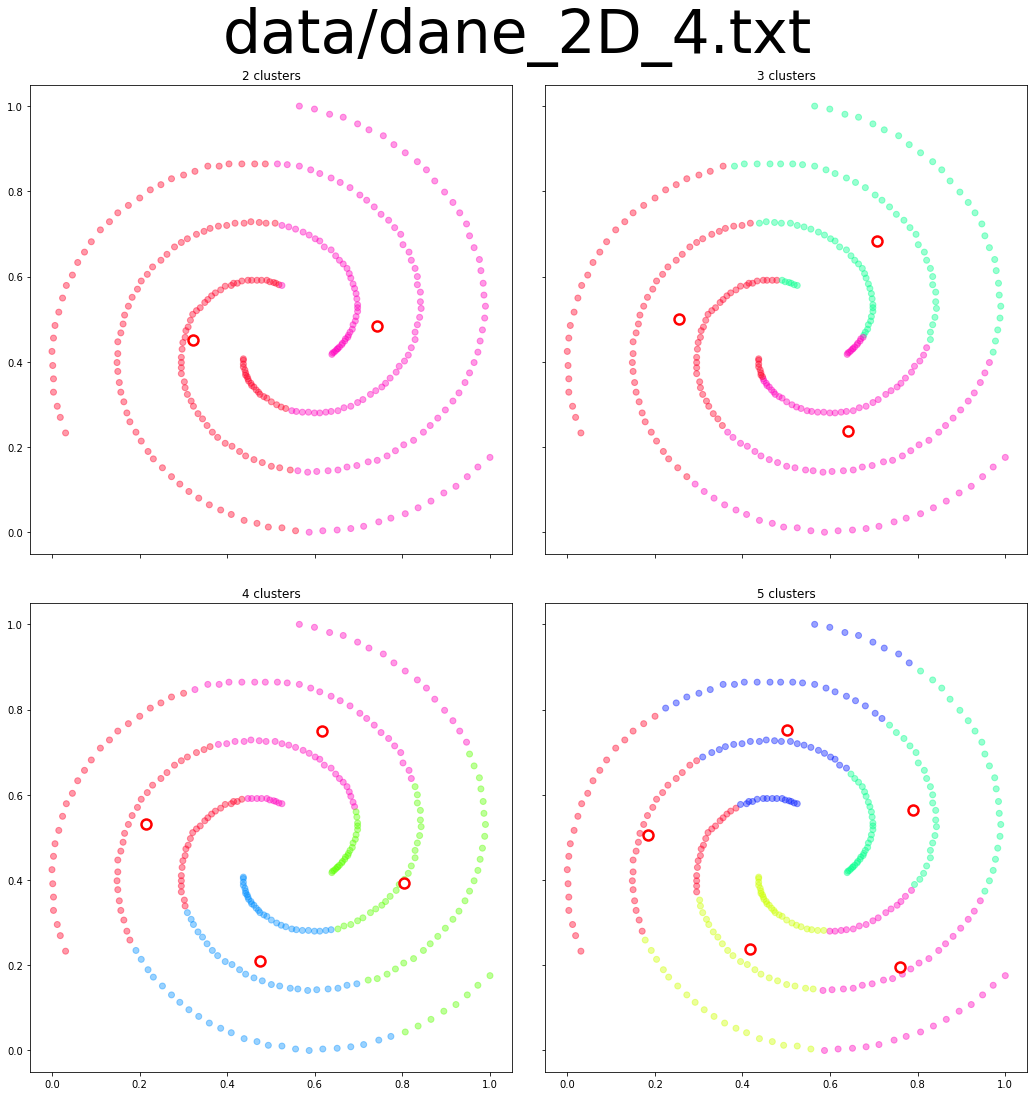

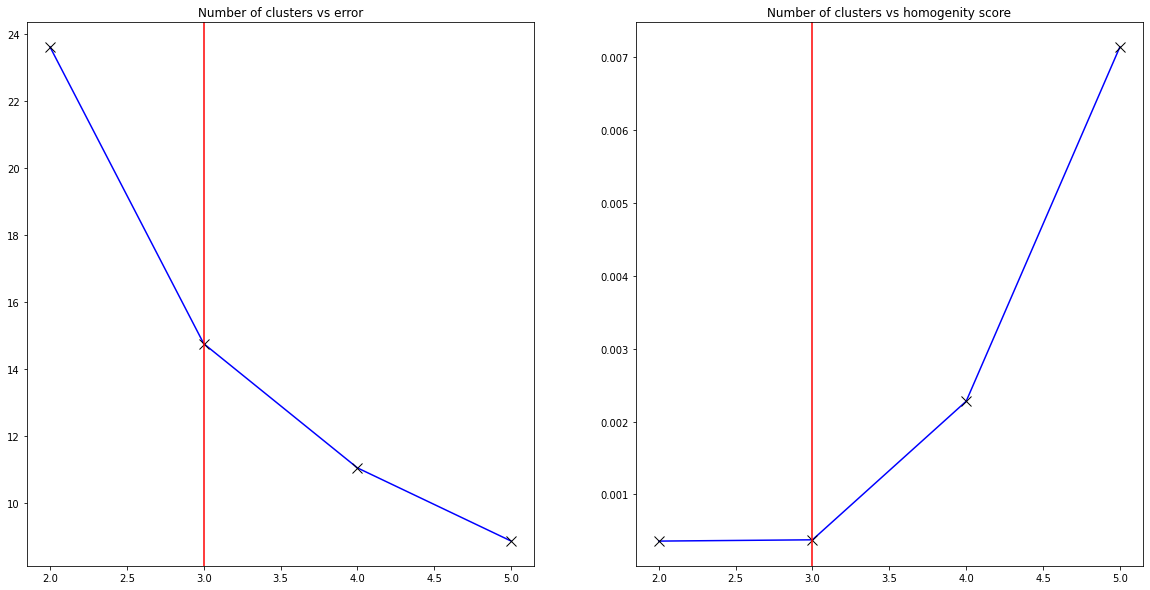

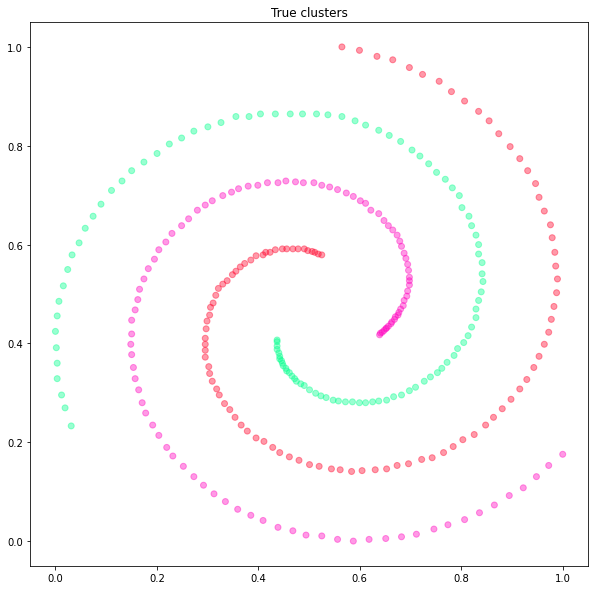

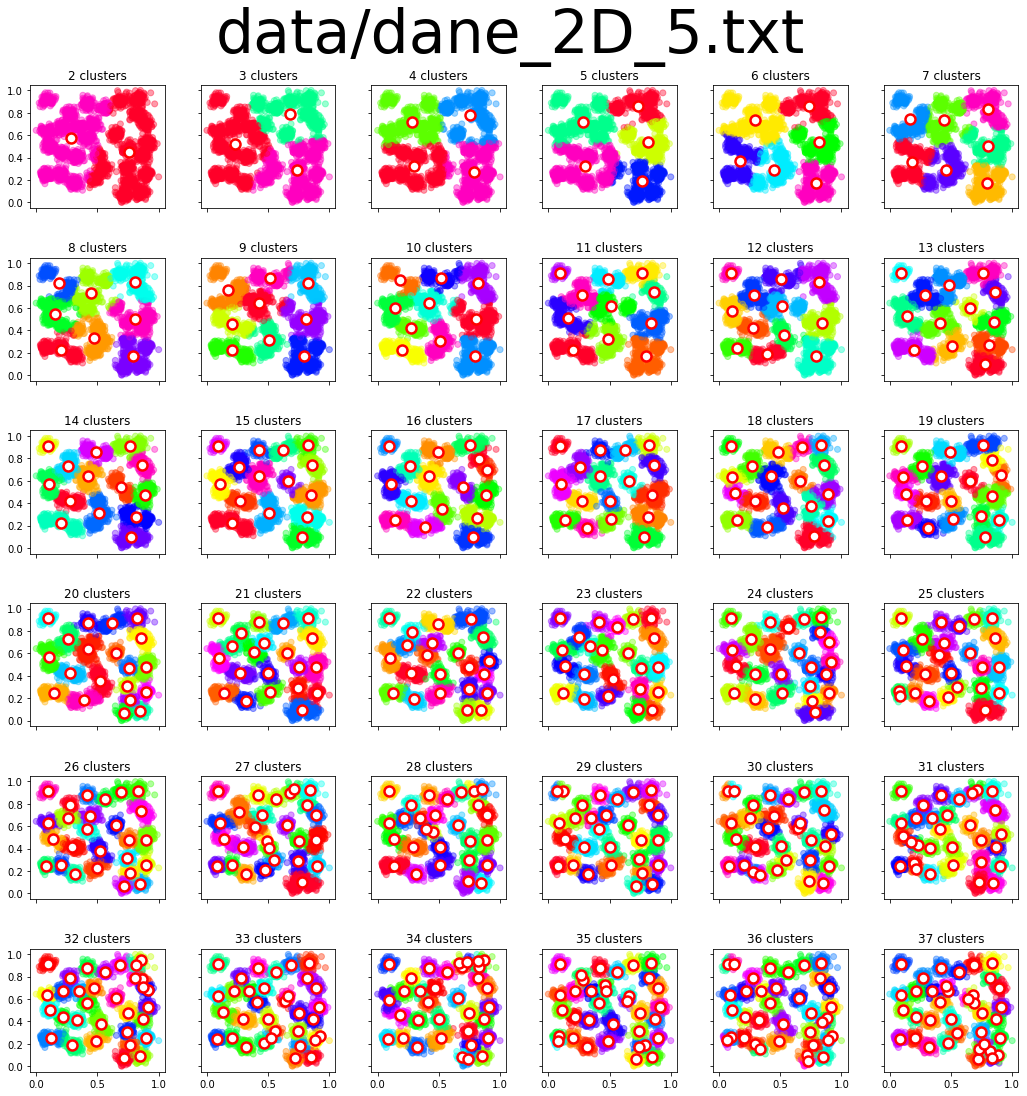

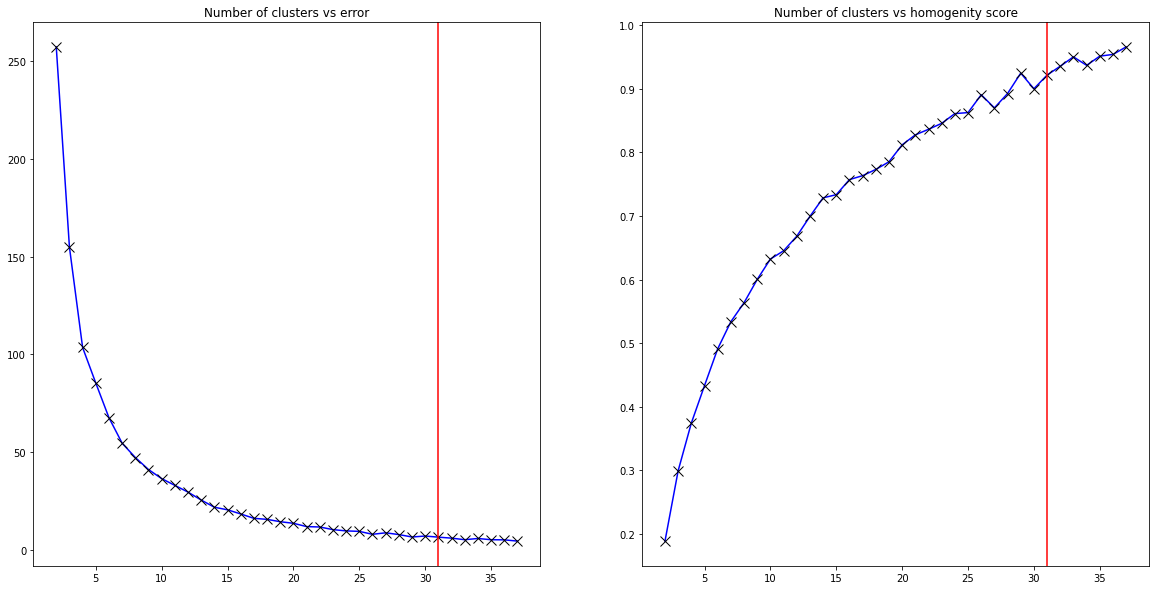

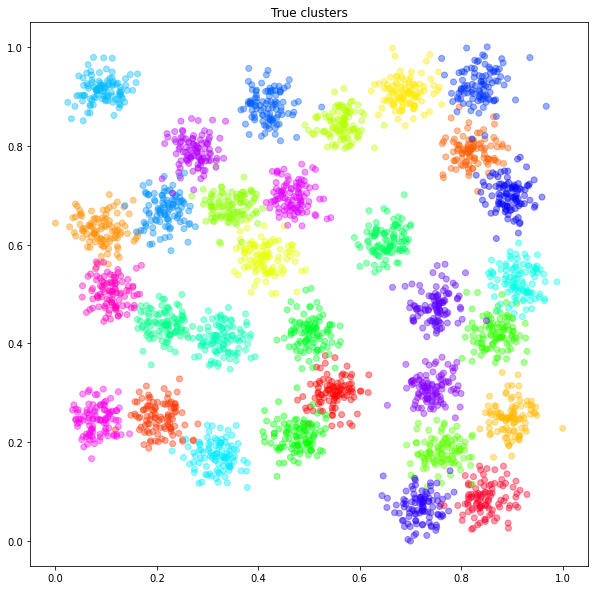

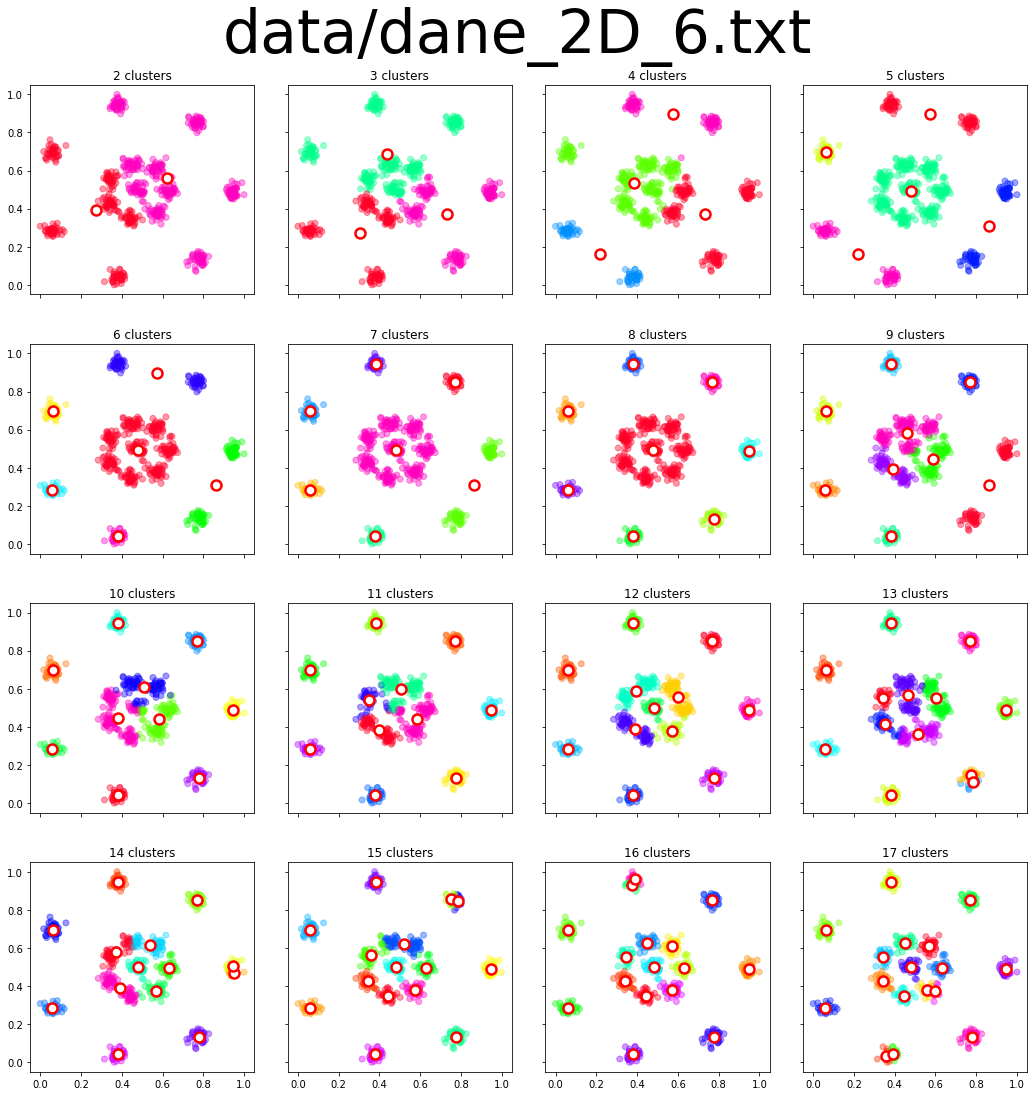

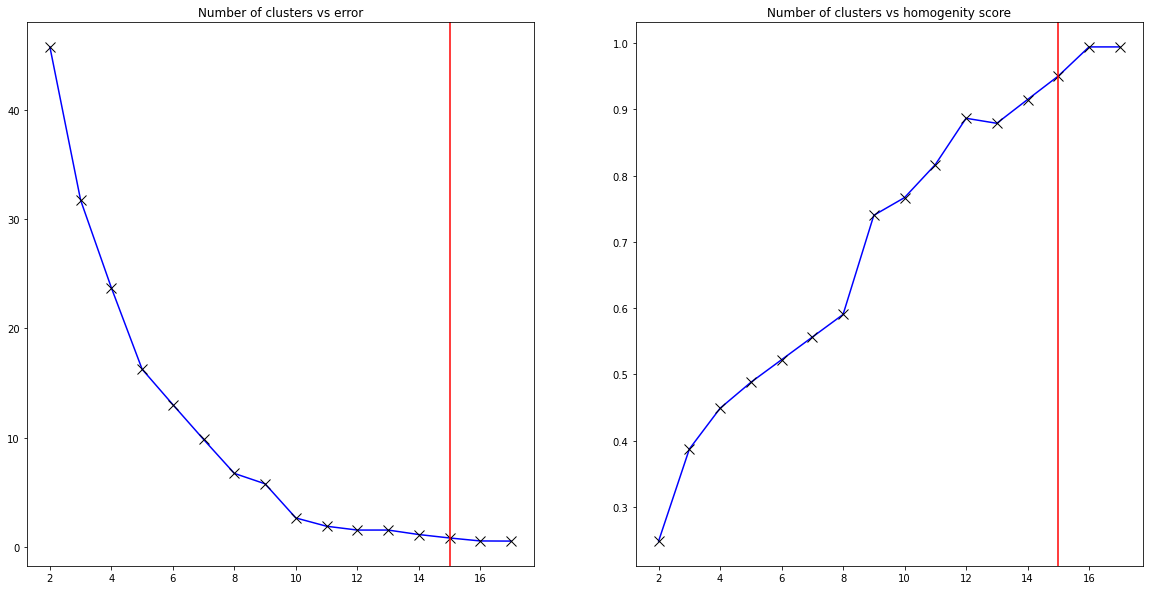

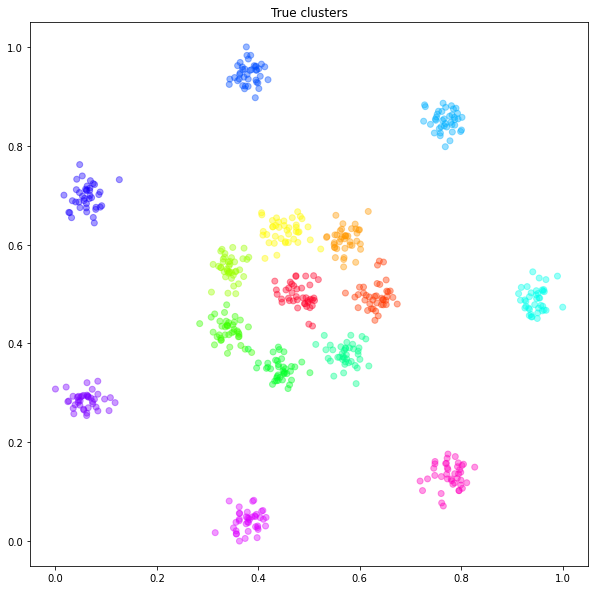

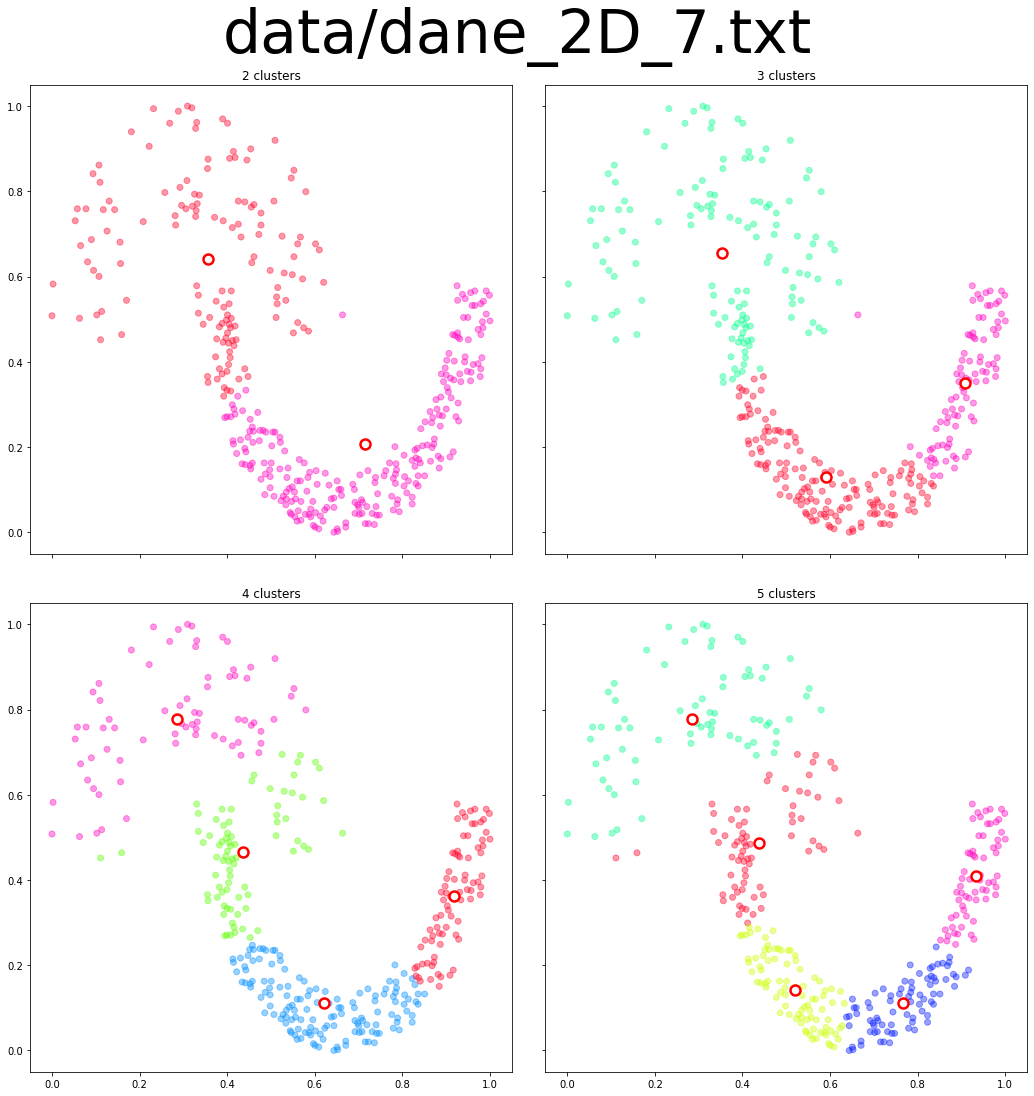

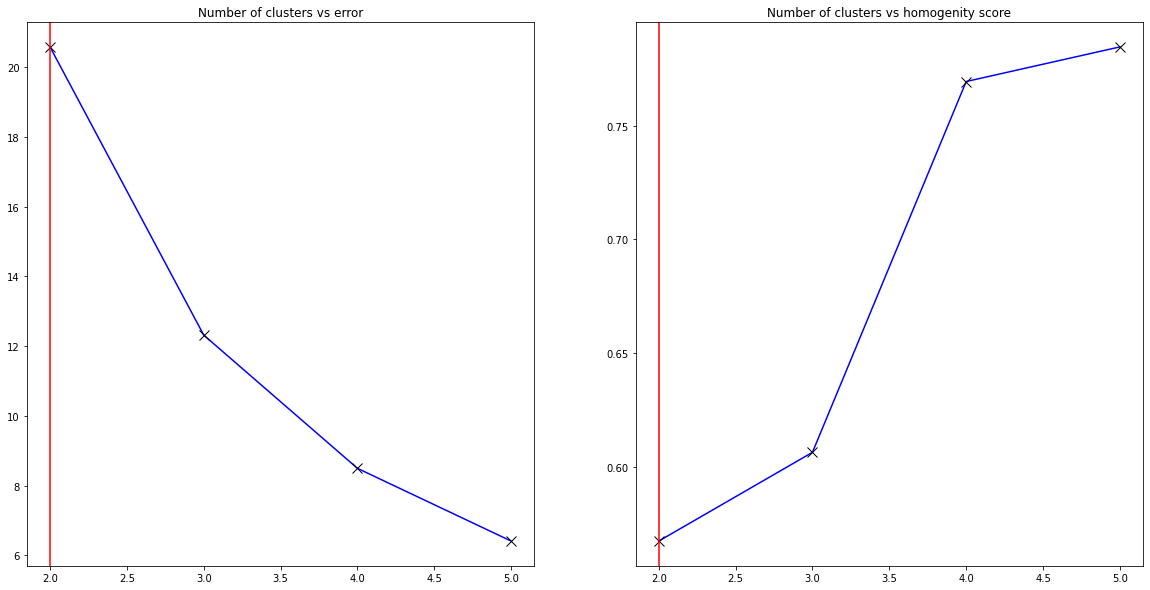

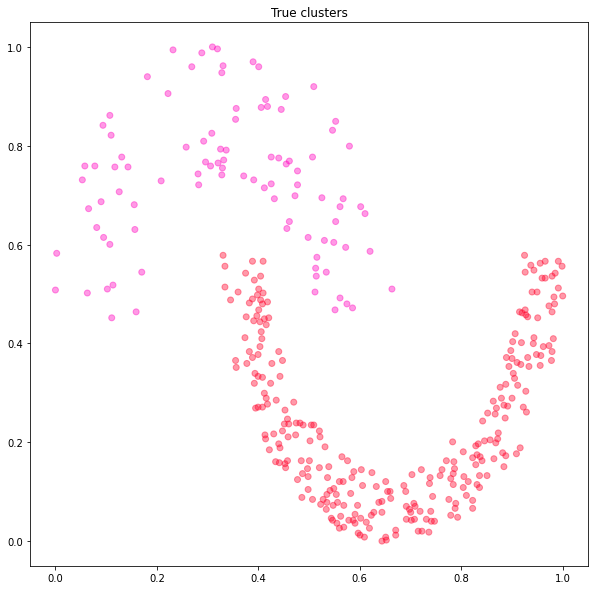

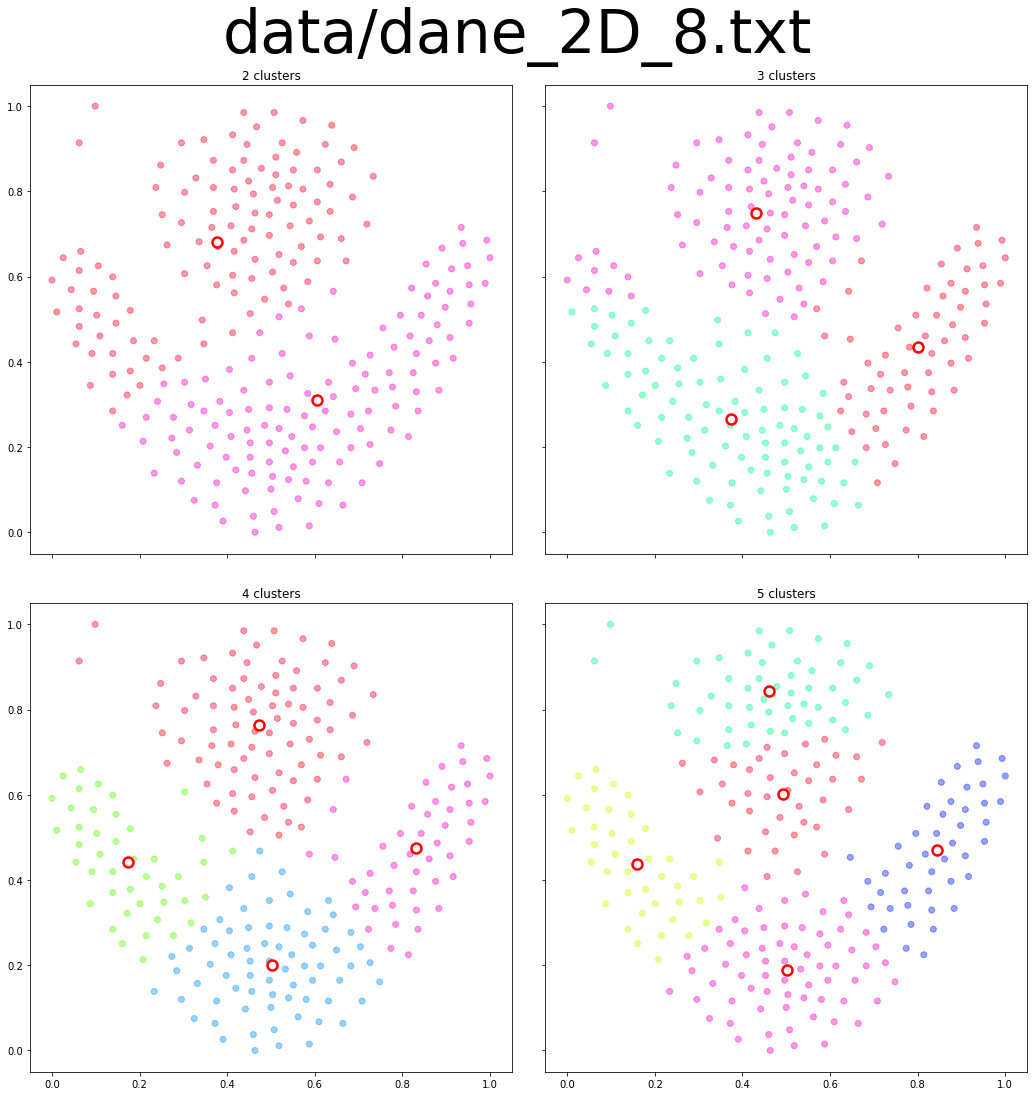

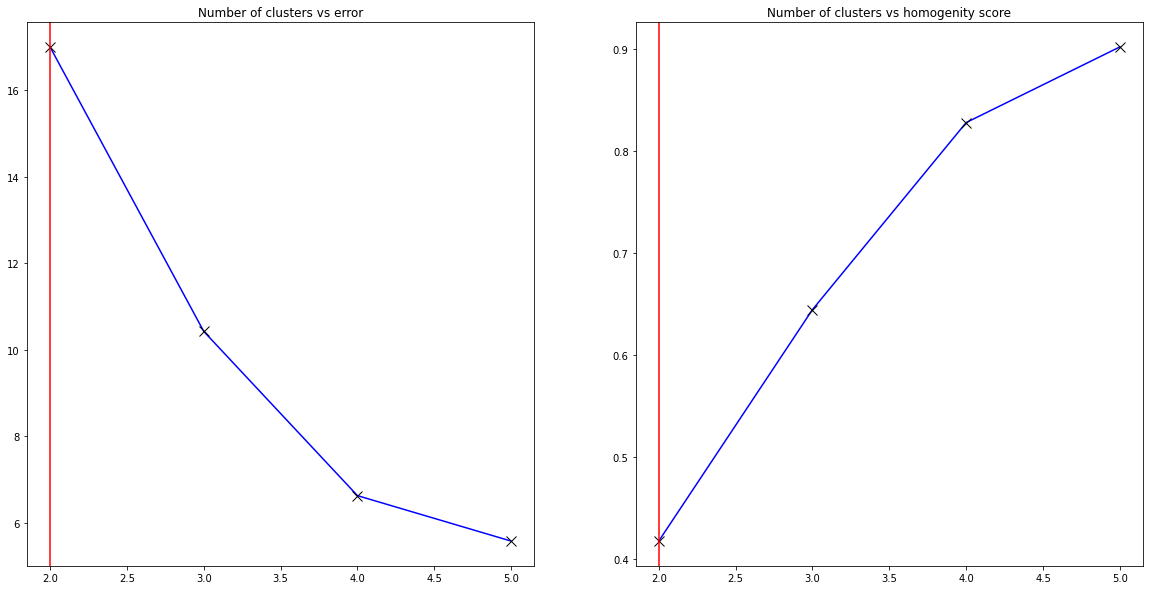

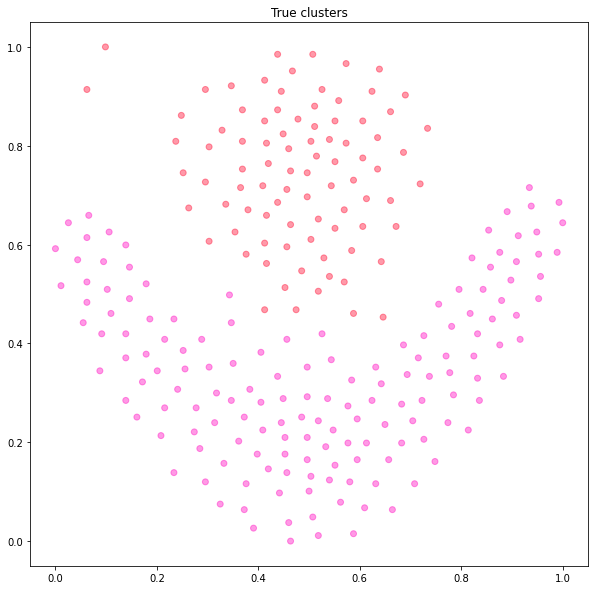

In [7]:
for dataset, max_k in zip(DATASETS_2D, DATASETS_2D_Ks):
    x, y = get_data_w_labels(dataset)
    y = y.astype(int).flatten() - 1
    handle_2D_dataset(x, y, dataset, max_k)

plt.show()

In [8]:
def handle_rp_dataset(x, y):
    ids, centroids = get_best_kmeans_clusterization(x, 2, 40)
    true_centroids = KMeans.compute_centroids(x, y, 2)

    print(f'Error after k-means: {KMeans.error(x, ids, centroids)}')
    print(f'Error from data:     {KMeans.error(x, y, true_centroids)}')
    print(f'Homogenity score:    {homogeneity_score(y, ids)}')


x_rp, y_rp = get_data_w_labels('data/rp.data')
y_rp = np.array(y_rp, dtype=int).flatten()
y_rp[y_rp == 2] = 0
y_rp[y_rp == 4] = 1
handle_rp_dataset(x_rp, y_rp)

Error after k-means: 238.55770144524584
Error from data:     255.63668573268842
Homogenity score:    0.7428932974186745


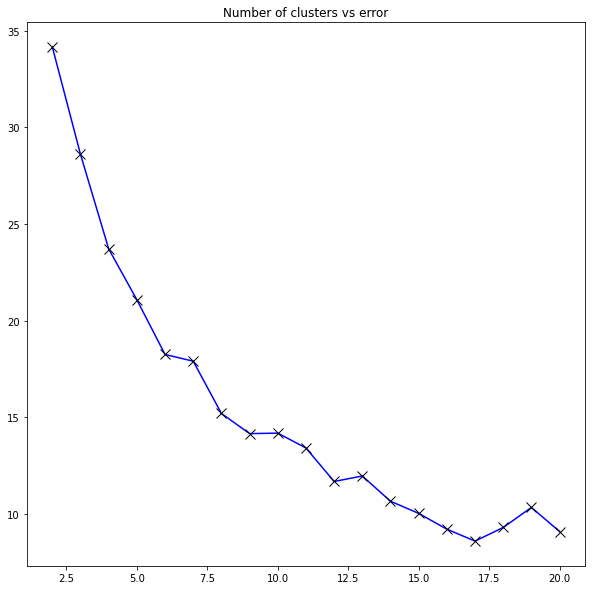

In [9]:
def handle_9D_dataset(x, max_k=20):
    errors = []
    for k in range(2, max_k + 1):
        ids, centroids = get_best_kmeans_clusterization(x, k, 10)
        errors.append(KMeans.error(x, ids, centroids))

    fig, ax_err = plt.subplots(figsize=(10, 10))
    ax_err.set_title(f'Number of clusters vs error')
    ax_err.plot(range(2, max_k + 1), errors, 'bx-', ms=10, mec='k')


x_9d = get_data_wo_labels('data/dane_9D.txt')
handle_9D_dataset(x_9d)